In [1]:
project_name = 'final-project'

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.utils import save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATA_DIR = '../input/humanfaces/lfw/'

In [4]:
import os

print(os.listdir(DATA_DIR))

['Princess_Maxima', 'Ali_Mohammed_Maher', 'Elvis_Stojko', 'Yves_Brodeur', 'Monica_Serra', 'Valeri_Bure', 'Jim_Edmonds', 'Gerry_Kelly', 'Tom_Kelly', 'Jeremy_Greenstock', 'Brad_Russ', 'Abdulaziz_Kamilov', 'Jimmy_Jimenez', 'Paula_Locke', 'Jeane_Kirkpatrick', 'Hugh_Jessiman', 'John_Robbins', 'Erika_Christensen', 'Sandy_Wise', 'Gala_Leon_Garcia', 'Jonathan_Byrd', 'Wang_Nan', 'Phil_Morris', 'Brooke_Gordon', 'Darrell_Issa', 'Luis_Figo', 'Boris_Berezovsky', 'Valerie_Thwaites', 'Theresa_May', 'Asa_Hutchinson', 'Douglas_Meester', 'Fernando_Alonso', 'Andy_Rooney', 'Jack_LaLanne', 'Ben_Braun', 'Bonnie_Fuller', 'George_Clooney', 'Mike_Maroth', 'Edward_James_Olmos', 'Billy_Crawford', 'Evelyn_Lauder', 'Martin_Brodeur', 'Mark_Gangloff', 'Bill_Elliott', 'Carol_Carmody', 'Michael_Phelps', 'Takenori_Kanzaki', 'Nicholas_Byron', 'Max_Mosley', 'Robert_Duvall', 'Andrew_Cuomo', 'Adrien_Brody', 'Raoul_Ruiz', 'Daniel_Barenboim', 'Jake_Brace', 'Osmond_Smith', 'Dennis_Hastert', 'Ryan_Leaf', 'Mona_Locke', 'Carlos_

In [5]:
print(os.listdir(DATA_DIR)[:10])

['Princess_Maxima', 'Ali_Mohammed_Maher', 'Elvis_Stojko', 'Yves_Brodeur', 'Monica_Serra', 'Valeri_Bure', 'Jim_Edmonds', 'Gerry_Kelly', 'Tom_Kelly', 'Jeremy_Greenstock']


In [320]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [321]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [322]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [323]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


In [324]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

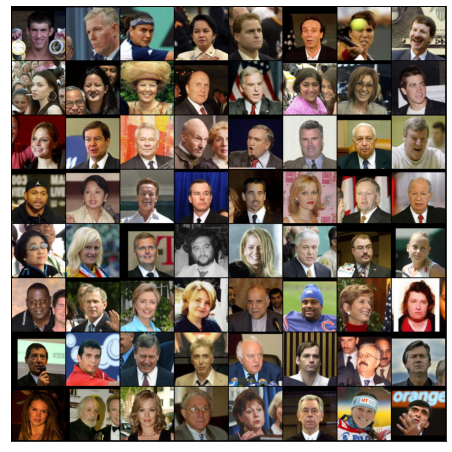

In [325]:
show_batch(train_dl)

In [326]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [327]:
device = get_default_device()
device

device(type='cuda')

In [328]:
train_dl = DeviceDataLoader(train_dl, device)

In [329]:
K_size = 4
pad = 1

In [330]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    
    nn.Conv2d(3, 32, kernel_size=K_size, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 16 x 16

    nn.Conv2d(32, 64, kernel_size=K_size, stride=2, padding=pad, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=K_size, stride=2, padding=pad, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=K_size, stride=2, padding=pad, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=K_size, stride=2, padding=pad, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=K_size, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [331]:
discriminator = to_device(discriminator, device)

# **Generator Network**

In [332]:
latent_size = 128
K_size = 4

In [333]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=K_size, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=K_size, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=K_size, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=K_size, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 32, kernel_size=K_size, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 8 x 8

    nn.ConvTranspose2d(32, 3, kernel_size=K_size, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 32 x 32
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 128, 128])


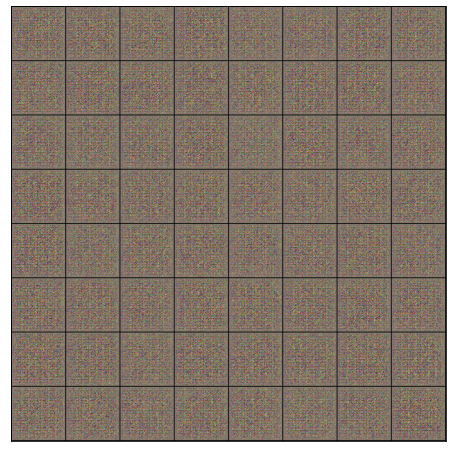

In [334]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [335]:
generator = to_device(generator, device)

# **Discrminator Training**

In [361]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [362]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [363]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [339]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [340]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)



Saving generated-images-0000.png


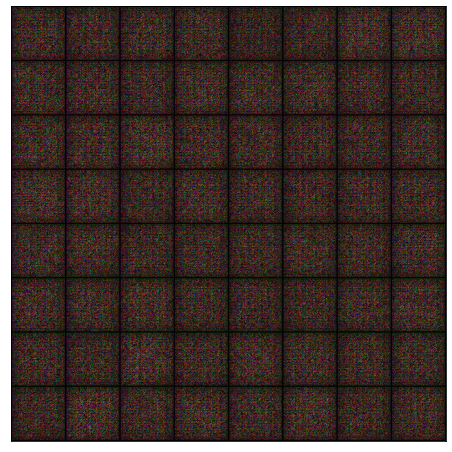

In [341]:
save_samples(0, fixed_latent)

In [342]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [343]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [417]:
lr = 0.0002
epochs = 100

In [420]:
!pip install jovian --upgrade --quiet
import jovian
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [397]:
history = fit(epochs, lr)


Epoch [1/50], loss_g: 2.6149, loss_d: 0.2672, real_score: 0.8574, fake_score: 0.0887
Saving generated-images-0001.png



Epoch [2/50], loss_g: 3.4868, loss_d: 0.1638, real_score: 0.9128, fake_score: 0.0562
Saving generated-images-0002.png



Epoch [3/50], loss_g: 3.4767, loss_d: 0.2245, real_score: 0.8484, fake_score: 0.0430
Saving generated-images-0003.png



Epoch [4/50], loss_g: 3.7795, loss_d: 0.0735, real_score: 0.9849, fake_score: 0.0532
Saving generated-images-0004.png



Epoch [5/50], loss_g: 3.4718, loss_d: 0.1335, real_score: 0.9311, fake_score: 0.0555
Saving generated-images-0005.png



Epoch [6/50], loss_g: 3.6355, loss_d: 0.0848, real_score: 0.9642, fake_score: 0.0455
Saving generated-images-0006.png



Epoch [7/50], loss_g: 3.5979, loss_d: 0.0816, real_score: 0.9641, fake_score: 0.0417
Saving generated-images-0007.png



Epoch [8/50], loss_g: 3.8128, loss_d: 0.0875, real_score: 0.9688, fake_score: 0.0518
Saving generated-images-0008.png



Epoch [9/50], loss_g: 3.8507, loss_d: 0.0842, real_score: 0.9605, fake_score: 0.0410
Saving generated-images-0009.png



Epoch [10/50], loss_g: 4.0342, loss_d: 0.0572, real_score: 0.9774, fake_score: 0.0327
Saving generated-images-0010.png



Epoch [11/50], loss_g: 3.9415, loss_d: 0.0668, real_score: 0.9673, fake_score: 0.0321
Saving generated-images-0011.png



Epoch [12/50], loss_g: 4.3069, loss_d: 0.0775, real_score: 0.9553, fake_score: 0.0297
Saving generated-images-0012.png



Epoch [13/50], loss_g: 3.9232, loss_d: 0.0482, real_score: 0.9781, fake_score: 0.0245
Saving generated-images-0013.png



Epoch [14/50], loss_g: 3.9348, loss_d: 0.0569, real_score: 0.9756, fake_score: 0.0299
Saving generated-images-0014.png



Epoch [15/50], loss_g: 4.0904, loss_d: 0.0897, real_score: 0.9601, fake_score: 0.0444
Saving generated-images-0015.png



Epoch [16/50], loss_g: 4.2223, loss_d: 0.1512, real_score: 0.8988, fake_score: 0.0362
Saving generated-images-0016.png



Epoch [17/50], loss_g: 3.8526, loss_d: 0.0582, real_score: 0.9766, fake_score: 0.0328
Saving generated-images-0017.png



Epoch [18/50], loss_g: 3.8310, loss_d: 0.1304, real_score: 0.9139, fake_score: 0.0339
Saving generated-images-0018.png



Epoch [19/50], loss_g: 4.1142, loss_d: 0.0832, real_score: 0.9518, fake_score: 0.0308
Saving generated-images-0019.png



Epoch [20/50], loss_g: 4.3670, loss_d: 0.0466, real_score: 0.9858, fake_score: 0.0307
Saving generated-images-0020.png



Epoch [21/50], loss_g: 4.2863, loss_d: 0.0683, real_score: 0.9622, fake_score: 0.0282
Saving generated-images-0021.png



Epoch [22/50], loss_g: 4.3703, loss_d: 0.0527, real_score: 0.9741, fake_score: 0.0253
Saving generated-images-0022.png



Epoch [23/50], loss_g: 4.3232, loss_d: 0.0893, real_score: 0.9579, fake_score: 0.0426
Saving generated-images-0023.png



Epoch [24/50], loss_g: 4.4887, loss_d: 0.0387, real_score: 0.9803, fake_score: 0.0181
Saving generated-images-0024.png



Epoch [25/50], loss_g: 4.2970, loss_d: 0.0563, real_score: 0.9714, fake_score: 0.0252
Saving generated-images-0025.png



Epoch [26/50], loss_g: 3.9001, loss_d: 0.0577, real_score: 0.9793, fake_score: 0.0344
Saving generated-images-0026.png



Epoch [30/50], loss_g: 4.4502, loss_d: 0.0559, real_score: 0.9613, fake_score: 0.0156
Saving generated-images-0030.png



Epoch [31/50], loss_g: 4.2061, loss_d: 0.0412, real_score: 0.9821, fake_score: 0.0223
Saving generated-images-0031.png



Epoch [32/50], loss_g: 4.7145, loss_d: 0.0640, real_score: 0.9689, fake_score: 0.0305
Saving generated-images-0032.png



Epoch [33/50], loss_g: 4.3521, loss_d: 0.0480, real_score: 0.9677, fake_score: 0.0144
Saving generated-images-0033.png



Epoch [34/50], loss_g: 4.4196, loss_d: 0.0499, real_score: 0.9705, fake_score: 0.0190
Saving generated-images-0034.png



Epoch [35/50], loss_g: 4.5132, loss_d: 0.0491, real_score: 0.9841, fake_score: 0.0314
Saving generated-images-0035.png



Epoch [36/50], loss_g: 4.5927, loss_d: 0.0794, real_score: 0.9461, fake_score: 0.0219
Saving generated-images-0036.png



Epoch [37/50], loss_g: 4.3538, loss_d: 0.0268, real_score: 0.9910, fake_score: 0.0172
Saving generated-images-0037.png



Epoch [38/50], loss_g: 4.8044, loss_d: 0.0272, real_score: 0.9886, fake_score: 0.0154
Saving generated-images-0038.png


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch [48/50], loss_g: 5.0034, loss_d: 0.0314, real_score: 0.9816, fake_score: 0.0124
Saving generated-images-0048.png



Epoch [49/50], loss_g: 5.3035, loss_d: 0.0289, real_score: 0.9865, fake_score: 0.0148
Saving generated-images-0049.png



Epoch [50/50], loss_g: 5.4018, loss_d: 0.0378, real_score: 0.9768, fake_score: 0.0137
Saving generated-images-0050.png


In [398]:
losses_g, losses_d, real_scores, fake_scores = history

In [399]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [400]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [401]:
from IPython.display import Image

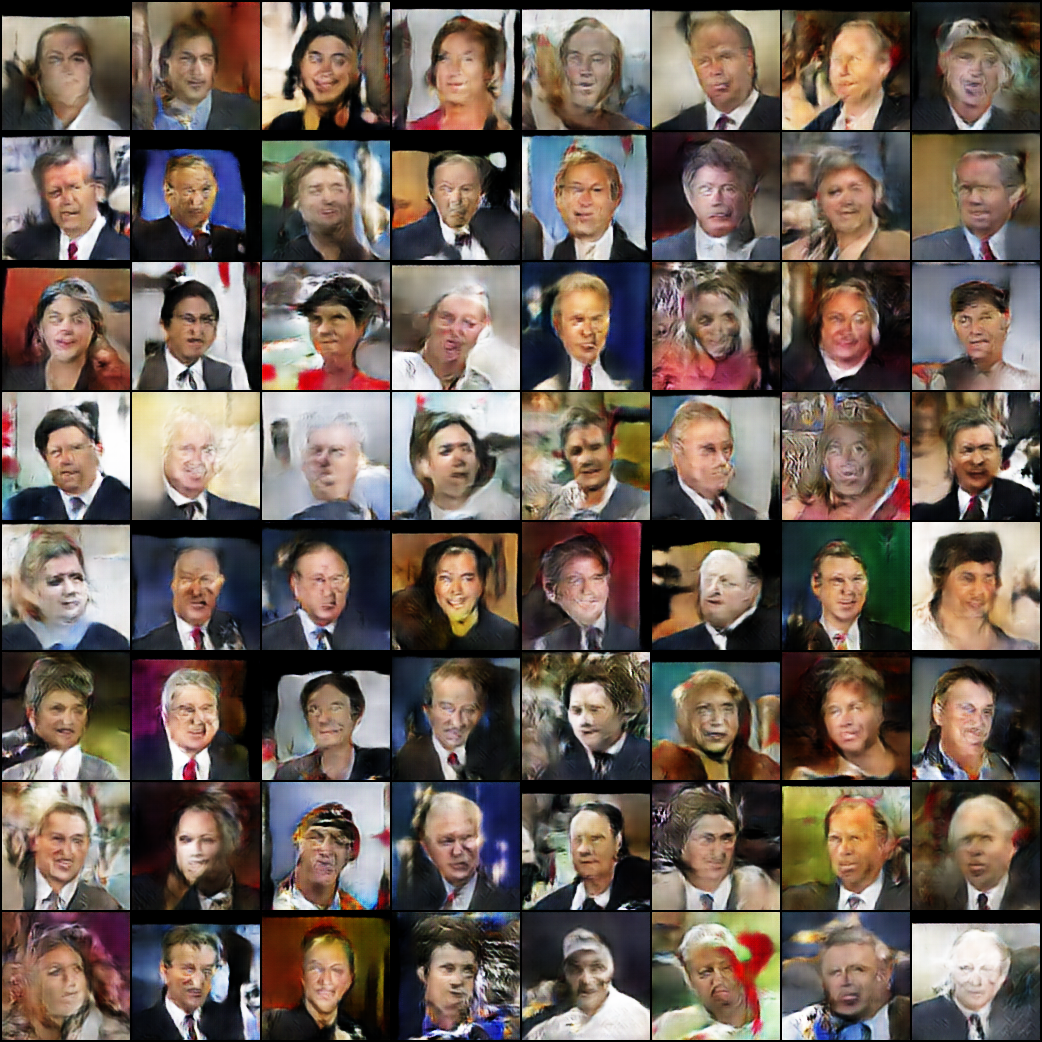

In [402]:
Image('./generated/generated-images-0050.png')

In [415]:
import cv2
import os

vid_fname = 'gans_training_128_50.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
print(files)
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'GPEG'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

['generated/generated-images-0046.png', 'generated/generated-images-0014.png', 'generated/generated-images-0007.png', 'generated/generated-images-0030.png', 'generated/generated-images-0027.png', 'generated/generated-images-0042.png', 'generated/generated-images-0024.png', 'generated/generated-images-0033.png', 'generated/generated-images-0013.png', 'generated/generated-images-0035.png', 'generated/generated-images-0019.png', 'generated/generated-images-0003.png', 'generated/generated-images-0044.png', 'generated/generated-images-0016.png', 'generated/generated-images-0040.png', 'generated/generated-images-0041.png', 'generated/generated-images-0022.png', 'generated/generated-images-0002.png', 'generated/generated-images-0032.png', 'generated/generated-images-0015.png', 'generated/generated-images-0026.png', 'generated/generated-images-0049.png', 'generated/generated-images-0006.png', 'generated/generated-images-0004.png', 'generated/generated-images-0034.png', 'generated/generated-ima

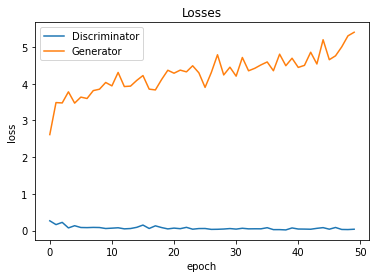

In [404]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

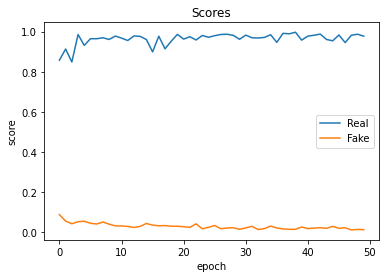

In [405]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [421]:
jovian.commit(project=project_name, 
              outputs=['G.ckpt', 'D.ckpt', 'gans_training_128_50.avi'], 
              environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sameer9406/final-project


<IPython.core.display.Javascript object>